In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import os
import math
import numpy as np

from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential, Model
from keras.optimizers import Adam, RMSprop,SGD

from keras.utils.np_utils import to_categorical
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score
from keras.layers import Dense, Input, Dropout, Activation, Conv2D, MaxPooling2D, Lambda, Flatten, GlobalAveragePooling2D
from keras.layers.merge import concatenate

from keras.applications.vgg16 import VGG16
from keras.applications.mobilenet import MobileNet
from keras.applications.resnet50 import ResNet50

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [3]:
train_dir = 'data-ISBI-resized/train/'
validation_dir = 'data-ISBI-resized/validation/'
test_dir = 'data-ISBI-resized/test/'

extracted_features_dir = "extracted_features/"
model_name = "VGG16_MobileNet_Concatenate3_ImageNetMean_RMSProp"

In [4]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

data-ISBI-resized/train/ 0
data-ISBI-resized/train/malignant 40425
data-ISBI-resized/train/normal 18747
******************************
data-ISBI-resized/test/ 0
data-ISBI-resized/test/malignant 655
data-ISBI-resized/test/normal 312


In [5]:
batch_size = 32
img_height, img_width = 380, 380
input_shape = (img_height, img_width, 3)
epochs = 1000

top_model_path = os.path.join(extracted_features_dir, 'model_'+model_name+'_model.h5')
top_model_weights_path = os.path.join(extracted_features_dir, 'model_'+model_name+'_weights.h5')

In [6]:
def preprocess_input(x):
    # 'RGB'->'BGR'
    x = x[:, :, ::-1]
    # Zero-center by imagenet mean pixel
    x[:, :, 0] -= 103.939
    x[:, :, 1] -= 116.779
    x[:, :, 2] -= 123.68
    return x

In [7]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=False,
    featurewise_std_normalization=False,
#     validation_split= 0.25,
    preprocessing_function = preprocess_input,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
#     subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
#     subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255, preprocessing_function = preprocess_input)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 59170 images belonging to 2 classes.
Found 18384 images belonging to 2 classes.
Found 967 images belonging to 2 classes.


In [8]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
nb_test_samples = len(test_generator.filenames)

predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("nb_test_samples:", nb_test_samples)

print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 59170
nb_validation_samples: 18384
nb_test_samples: 967

predict_size_train: 1850
predict_size_validation: 575
predict_size_test: 31

 num_classes: 2


In [9]:
basemodel1=VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
x1=basemodel1.get_layer('block5_pool').output
x1=GlobalAveragePooling2D()(x1)

basemodel2=MobileNet(weights=None,input_tensor = basemodel1.input, include_top=False, input_shape=input_shape)
x2 = basemodel2.output
x2 = GlobalAveragePooling2D()(x2)

merge = concatenate([x1, x2])
merge = Dropout(0.6)(merge)
preds = Dense(num_classes, activation='relu')(merge)
model = Model(inputs=basemodel1.input,outputs=preds)

In [10]:
# bottleneck_final_model.summary()
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 input_1
1 conv1_pad
2 conv1
3 conv1_bn
4 conv1_relu
5 conv_dw_1
6 conv_dw_1_bn
7 conv_dw_1_relu
8 conv_pw_1
9 conv_pw_1_bn
10 conv_pw_1_relu
11 conv_pad_2
12 conv_dw_2
13 conv_dw_2_bn
14 conv_dw_2_relu
15 conv_pw_2
16 conv_pw_2_bn
17 conv_pw_2_relu
18 conv_dw_3
19 conv_dw_3_bn
20 conv_dw_3_relu
21 conv_pw_3
22 conv_pw_3_bn
23 conv_pw_3_relu
24 conv_pad_4
25 conv_dw_4
26 conv_dw_4_bn
27 conv_dw_4_relu
28 conv_pw_4
29 conv_pw_4_bn
30 conv_pw_4_relu
31 conv_dw_5
32 conv_dw_5_bn
33 conv_dw_5_relu
34 conv_pw_5
35 conv_pw_5_bn
36 conv_pw_5_relu
37 conv_pad_6
38 conv_dw_6
39 conv_dw_6_bn
40 conv_dw_6_relu
41 conv_pw_6
42 conv_pw_6_bn
43 conv_pw_6_relu
44 conv_dw_7
45 conv_dw_7_bn
46 conv_dw_7_relu
47 conv_pw_7
48 conv_pw_7_bn
49 conv_pw_7_relu
50 conv_dw_8
51 conv_dw_8_bn
52 conv_dw_8_relu
53 conv_pw_8
54 conv_pw_8_bn
55 conv_pw_8_relu
56 conv_dw_9
57 conv_dw_9_bn
58 conv_dw_9_relu
59 conv_pw_9
60 conv_pw_9_bn
61 conv_pw_9_relu
62 conv_dw_10
63 conv_dw_10_bn
64 conv_dw_10_relu
65 conv_pw_10

In [11]:
c1 = model.layers[74].output 
c1 = GlobalAveragePooling2D()(c1)       

c2 = model.layers[80].output
c2 = GlobalAveragePooling2D()(c2)       

c3 = model.layers[88].output
c3 = GlobalAveragePooling2D()(c3)       

c4 = model.layers[96].output
c4 = GlobalAveragePooling2D()(c4)

c5 = model.layers[103].output
c5 = GlobalAveragePooling2D()(c5)


con = concatenate([c1,c2,c3,c4,c5])

bottleneck_final_model = Model(inputs=model.input, outputs=con)

In [12]:
bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train, max_q_size=1, pickle_safe=False)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [13]:
bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

In [14]:
bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [15]:
import tensorflow as tf
from keras.backend.tensorflow_backend import get_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import set_session

def reset_keras_tf_session():
    """
    this function clears the gpu memory and set the 
    tf session to not use the whole gpu
    """
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    set_session(tf.Session(config=config))


reset_keras_tf_session()

In [16]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [17]:
model = Sequential()
# model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))

rmsprop_opt=RMSprop(lr=0.0001, rho=0.8, epsilon=None, decay=0.0)

model.compile(optimizer=rmsprop_opt, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

with open(extracted_features_dir+'history_'+model_name+'.txt','w') as f:
    f.write(str(history.history))

model.save_weights(top_model_weights_path)
model.save(top_model_path)

Train on 59170 samples, validate on 18384 samples
Epoch 1/1000
 - 8s - loss: 0.5305 - acc: 0.7512 - val_loss: 0.4937 - val_acc: 0.7788
Epoch 2/1000
 - 7s - loss: 0.4913 - acc: 0.7803 - val_loss: 0.4856 - val_acc: 0.7819
Epoch 3/1000
 - 7s - loss: 0.4845 - acc: 0.7843 - val_loss: 0.4850 - val_acc: 0.7836
Epoch 4/1000
 - 7s - loss: 0.4791 - acc: 0.7873 - val_loss: 0.4753 - val_acc: 0.7899
Epoch 5/1000
 - 7s - loss: 0.4740 - acc: 0.7888 - val_loss: 0.4713 - val_acc: 0.7916
Epoch 6/1000
 - 7s - loss: 0.4695 - acc: 0.7922 - val_loss: 0.4686 - val_acc: 0.7942
Epoch 7/1000
 - 7s - loss: 0.4654 - acc: 0.7944 - val_loss: 0.4638 - val_acc: 0.7972
Epoch 8/1000
 - 7s - loss: 0.4610 - acc: 0.7976 - val_loss: 0.4615 - val_acc: 0.7995
Epoch 9/1000
 - 7s - loss: 0.4585 - acc: 0.7971 - val_loss: 0.4572 - val_acc: 0.8031
Epoch 10/1000
 - 7s - loss: 0.4544 - acc: 0.8005 - val_loss: 0.4548 - val_acc: 0.8042
Epoch 11/1000
 - 7s - loss: 0.4513 - acc: 0.8013 - val_loss: 0.4518 - val_acc: 0.8072
Epoch 12/1000

Epoch 96/1000
 - 7s - loss: 0.3917 - acc: 0.8369 - val_loss: 0.4203 - val_acc: 0.8282
Epoch 97/1000
 - 7s - loss: 0.3909 - acc: 0.8381 - val_loss: 0.4249 - val_acc: 0.8273
Epoch 98/1000
 - 7s - loss: 0.3921 - acc: 0.8376 - val_loss: 0.4226 - val_acc: 0.8281
Epoch 99/1000
 - 7s - loss: 0.3902 - acc: 0.8381 - val_loss: 0.4301 - val_acc: 0.8198
Epoch 100/1000
 - 7s - loss: 0.3908 - acc: 0.8382 - val_loss: 0.4184 - val_acc: 0.8284
Epoch 101/1000
 - 7s - loss: 0.3897 - acc: 0.8368 - val_loss: 0.4408 - val_acc: 0.8225
Epoch 102/1000
 - 7s - loss: 0.3908 - acc: 0.8380 - val_loss: 0.4220 - val_acc: 0.8262
Epoch 103/1000
 - 7s - loss: 0.3908 - acc: 0.8371 - val_loss: 0.4237 - val_acc: 0.8274
Epoch 104/1000
 - 7s - loss: 0.3896 - acc: 0.8370 - val_loss: 0.4258 - val_acc: 0.8243
Epoch 105/1000
 - 7s - loss: 0.3896 - acc: 0.8374 - val_loss: 0.4203 - val_acc: 0.8296
Epoch 106/1000
 - 7s - loss: 0.3901 - acc: 0.8381 - val_loss: 0.4207 - val_acc: 0.8279
Epoch 107/1000
 - 7s - loss: 0.3892 - acc: 0.83

Epoch 191/1000
 - 7s - loss: 0.3769 - acc: 0.8472 - val_loss: 0.4323 - val_acc: 0.8292
Epoch 192/1000
 - 7s - loss: 0.3766 - acc: 0.8476 - val_loss: 0.4368 - val_acc: 0.8222
Epoch 193/1000
 - 7s - loss: 0.3779 - acc: 0.8461 - val_loss: 0.4295 - val_acc: 0.8279
Epoch 194/1000
 - 7s - loss: 0.3758 - acc: 0.8469 - val_loss: 0.4318 - val_acc: 0.8289
Epoch 195/1000
 - 7s - loss: 0.3772 - acc: 0.8463 - val_loss: 0.4394 - val_acc: 0.8216
Epoch 196/1000
 - 7s - loss: 0.3774 - acc: 0.8463 - val_loss: 0.4329 - val_acc: 0.8264
Epoch 197/1000
 - 7s - loss: 0.3762 - acc: 0.8459 - val_loss: 0.4342 - val_acc: 0.8234
Epoch 198/1000
 - 7s - loss: 0.3762 - acc: 0.8469 - val_loss: 0.4355 - val_acc: 0.8264
Epoch 199/1000
 - 7s - loss: 0.3762 - acc: 0.8471 - val_loss: 0.4468 - val_acc: 0.8179
Epoch 200/1000
 - 7s - loss: 0.3771 - acc: 0.8465 - val_loss: 0.4401 - val_acc: 0.8250
Epoch 201/1000
 - 7s - loss: 0.3755 - acc: 0.8467 - val_loss: 0.4650 - val_acc: 0.8084
Epoch 202/1000
 - 7s - loss: 0.3752 - acc: 

 - 8s - loss: 0.3671 - acc: 0.8525 - val_loss: 0.4595 - val_acc: 0.8174
Epoch 286/1000
 - 8s - loss: 0.3661 - acc: 0.8539 - val_loss: 0.4466 - val_acc: 0.8287
Epoch 287/1000
 - 7s - loss: 0.3674 - acc: 0.8525 - val_loss: 0.4444 - val_acc: 0.8268
Epoch 288/1000
 - 7s - loss: 0.3682 - acc: 0.8532 - val_loss: 0.4433 - val_acc: 0.8275
Epoch 289/1000
 - 7s - loss: 0.3668 - acc: 0.8527 - val_loss: 0.4461 - val_acc: 0.8246
Epoch 290/1000
 - 7s - loss: 0.3679 - acc: 0.8537 - val_loss: 0.4602 - val_acc: 0.8165
Epoch 291/1000
 - 7s - loss: 0.3677 - acc: 0.8542 - val_loss: 0.4526 - val_acc: 0.8238
Epoch 292/1000
 - 7s - loss: 0.3661 - acc: 0.8534 - val_loss: 0.4553 - val_acc: 0.8244
Epoch 293/1000
 - 7s - loss: 0.3673 - acc: 0.8532 - val_loss: 0.4416 - val_acc: 0.8250
Epoch 294/1000
 - 7s - loss: 0.3672 - acc: 0.8548 - val_loss: 0.4486 - val_acc: 0.8261
Epoch 295/1000
 - 7s - loss: 0.3654 - acc: 0.8533 - val_loss: 0.4490 - val_acc: 0.8271
Epoch 296/1000
 - 7s - loss: 0.3661 - acc: 0.8536 - val_lo

Epoch 380/1000
 - 7s - loss: 0.3601 - acc: 0.8580 - val_loss: 0.4568 - val_acc: 0.8231
Epoch 381/1000
 - 7s - loss: 0.3582 - acc: 0.8580 - val_loss: 0.4481 - val_acc: 0.8277
Epoch 382/1000
 - 7s - loss: 0.3597 - acc: 0.8581 - val_loss: 0.4632 - val_acc: 0.8242
Epoch 383/1000
 - 6s - loss: 0.3590 - acc: 0.8586 - val_loss: 0.4514 - val_acc: 0.8235
Epoch 384/1000
 - 6s - loss: 0.3579 - acc: 0.8594 - val_loss: 0.4548 - val_acc: 0.8277
Epoch 385/1000
 - 6s - loss: 0.3598 - acc: 0.8587 - val_loss: 0.4519 - val_acc: 0.8268
Epoch 386/1000
 - 6s - loss: 0.3584 - acc: 0.8591 - val_loss: 0.4685 - val_acc: 0.8217
Epoch 387/1000
 - 6s - loss: 0.3572 - acc: 0.8591 - val_loss: 0.4617 - val_acc: 0.8268
Epoch 388/1000
 - 6s - loss: 0.3599 - acc: 0.8582 - val_loss: 0.4774 - val_acc: 0.8192
Epoch 389/1000
 - 6s - loss: 0.3587 - acc: 0.8584 - val_loss: 0.4548 - val_acc: 0.8262
Epoch 390/1000
 - 6s - loss: 0.3589 - acc: 0.8598 - val_loss: 0.4544 - val_acc: 0.8247
Epoch 391/1000
 - 6s - loss: 0.3593 - acc: 

 - 6s - loss: 0.3531 - acc: 0.8635 - val_loss: 0.4688 - val_acc: 0.8235
Epoch 475/1000
 - 6s - loss: 0.3524 - acc: 0.8638 - val_loss: 0.4600 - val_acc: 0.8273
Epoch 476/1000
 - 6s - loss: 0.3540 - acc: 0.8633 - val_loss: 0.4624 - val_acc: 0.8273
Epoch 477/1000
 - 6s - loss: 0.3536 - acc: 0.8622 - val_loss: 0.4683 - val_acc: 0.8255
Epoch 478/1000
 - 6s - loss: 0.3539 - acc: 0.8629 - val_loss: 0.4675 - val_acc: 0.8239
Epoch 479/1000
 - 6s - loss: 0.3538 - acc: 0.8642 - val_loss: 0.4976 - val_acc: 0.8188
Epoch 480/1000
 - 6s - loss: 0.3552 - acc: 0.8636 - val_loss: 0.4721 - val_acc: 0.8269
Epoch 481/1000
 - 6s - loss: 0.3531 - acc: 0.8635 - val_loss: 0.4758 - val_acc: 0.8252
Epoch 482/1000
 - 6s - loss: 0.3546 - acc: 0.8636 - val_loss: 0.4821 - val_acc: 0.8222
Epoch 483/1000
 - 6s - loss: 0.3546 - acc: 0.8621 - val_loss: 0.4981 - val_acc: 0.8158
Epoch 484/1000
 - 6s - loss: 0.3541 - acc: 0.8640 - val_loss: 0.4686 - val_acc: 0.8264
Epoch 485/1000
 - 6s - loss: 0.3536 - acc: 0.8629 - val_lo

Epoch 569/1000
 - 6s - loss: 0.3474 - acc: 0.8682 - val_loss: 0.4830 - val_acc: 0.8224
Epoch 570/1000
 - 6s - loss: 0.3480 - acc: 0.8669 - val_loss: 0.4819 - val_acc: 0.8239
Epoch 571/1000
 - 6s - loss: 0.3474 - acc: 0.8661 - val_loss: 0.4796 - val_acc: 0.8257
Epoch 572/1000
 - 6s - loss: 0.3485 - acc: 0.8668 - val_loss: 0.4823 - val_acc: 0.8242
Epoch 573/1000
 - 6s - loss: 0.3471 - acc: 0.8669 - val_loss: 0.4859 - val_acc: 0.8221
Epoch 574/1000
 - 6s - loss: 0.3481 - acc: 0.8681 - val_loss: 0.4717 - val_acc: 0.8270
Epoch 575/1000
 - 7s - loss: 0.3490 - acc: 0.8669 - val_loss: 0.4810 - val_acc: 0.8265
Epoch 576/1000
 - 7s - loss: 0.3472 - acc: 0.8686 - val_loss: 0.4718 - val_acc: 0.8253
Epoch 577/1000
 - 7s - loss: 0.3476 - acc: 0.8665 - val_loss: 0.4945 - val_acc: 0.8254
Epoch 578/1000
 - 7s - loss: 0.3483 - acc: 0.8677 - val_loss: 0.4777 - val_acc: 0.8245
Epoch 579/1000
 - 7s - loss: 0.3489 - acc: 0.8668 - val_loss: 0.4828 - val_acc: 0.8257
Epoch 580/1000
 - 7s - loss: 0.3481 - acc: 

 - 6s - loss: 0.3457 - acc: 0.8695 - val_loss: 0.4836 - val_acc: 0.8238
Epoch 664/1000
 - 6s - loss: 0.3436 - acc: 0.8699 - val_loss: 0.4933 - val_acc: 0.8222
Epoch 665/1000
 - 6s - loss: 0.3444 - acc: 0.8709 - val_loss: 0.5057 - val_acc: 0.8207
Epoch 666/1000
 - 6s - loss: 0.3462 - acc: 0.8705 - val_loss: 0.5195 - val_acc: 0.8213
Epoch 667/1000
 - 6s - loss: 0.3434 - acc: 0.8712 - val_loss: 0.4928 - val_acc: 0.8247
Epoch 668/1000
 - 6s - loss: 0.3445 - acc: 0.8707 - val_loss: 0.4924 - val_acc: 0.8239
Epoch 669/1000
 - 6s - loss: 0.3438 - acc: 0.8710 - val_loss: 0.5000 - val_acc: 0.8213
Epoch 670/1000
 - 6s - loss: 0.3436 - acc: 0.8711 - val_loss: 0.4857 - val_acc: 0.8255
Epoch 671/1000
 - 6s - loss: 0.3449 - acc: 0.8700 - val_loss: 0.4980 - val_acc: 0.8225
Epoch 672/1000
 - 6s - loss: 0.3437 - acc: 0.8703 - val_loss: 0.4984 - val_acc: 0.8229
Epoch 673/1000
 - 6s - loss: 0.3450 - acc: 0.8712 - val_loss: 0.4865 - val_acc: 0.8252
Epoch 674/1000
 - 6s - loss: 0.3434 - acc: 0.8720 - val_lo

Epoch 758/1000
 - 6s - loss: 0.3427 - acc: 0.8719 - val_loss: 0.5203 - val_acc: 0.8223
Epoch 759/1000
 - 6s - loss: 0.3413 - acc: 0.8718 - val_loss: 0.5307 - val_acc: 0.8216
Epoch 760/1000
 - 6s - loss: 0.3421 - acc: 0.8732 - val_loss: 0.5619 - val_acc: 0.8134
Epoch 761/1000
 - 6s - loss: 0.3412 - acc: 0.8740 - val_loss: 0.5089 - val_acc: 0.8238
Epoch 762/1000
 - 6s - loss: 0.3430 - acc: 0.8721 - val_loss: 0.5051 - val_acc: 0.8243
Epoch 763/1000
 - 6s - loss: 0.3438 - acc: 0.8717 - val_loss: 0.5166 - val_acc: 0.8223
Epoch 764/1000
 - 6s - loss: 0.3403 - acc: 0.8736 - val_loss: 0.5096 - val_acc: 0.8241
Epoch 765/1000
 - 6s - loss: 0.3432 - acc: 0.8726 - val_loss: 0.5137 - val_acc: 0.8226
Epoch 766/1000
 - 6s - loss: 0.3419 - acc: 0.8729 - val_loss: 0.5311 - val_acc: 0.8196
Epoch 767/1000
 - 6s - loss: 0.3419 - acc: 0.8729 - val_loss: 0.5013 - val_acc: 0.8251
Epoch 768/1000
 - 6s - loss: 0.3430 - acc: 0.8735 - val_loss: 0.5138 - val_acc: 0.8240
Epoch 769/1000
 - 6s - loss: 0.3403 - acc: 

 - 6s - loss: 0.3389 - acc: 0.8748 - val_loss: 0.5123 - val_acc: 0.8258
Epoch 853/1000
 - 6s - loss: 0.3423 - acc: 0.8741 - val_loss: 0.5167 - val_acc: 0.8196
Epoch 854/1000
 - 6s - loss: 0.3412 - acc: 0.8745 - val_loss: 0.5162 - val_acc: 0.8229
Epoch 855/1000
 - 6s - loss: 0.3390 - acc: 0.8748 - val_loss: 0.5190 - val_acc: 0.8234
Epoch 856/1000
 - 6s - loss: 0.3401 - acc: 0.8738 - val_loss: 0.5282 - val_acc: 0.8244
Epoch 857/1000
 - 6s - loss: 0.3388 - acc: 0.8754 - val_loss: 0.5419 - val_acc: 0.8203
Epoch 858/1000
 - 6s - loss: 0.3401 - acc: 0.8761 - val_loss: 0.5194 - val_acc: 0.8224
Epoch 859/1000
 - 6s - loss: 0.3410 - acc: 0.8755 - val_loss: 0.5159 - val_acc: 0.8232
Epoch 860/1000
 - 6s - loss: 0.3376 - acc: 0.8763 - val_loss: 0.5309 - val_acc: 0.8216
Epoch 861/1000
 - 6s - loss: 0.3384 - acc: 0.8749 - val_loss: 0.5572 - val_acc: 0.8180
Epoch 862/1000
 - 6s - loss: 0.3414 - acc: 0.8757 - val_loss: 0.5224 - val_acc: 0.8198
Epoch 863/1000
 - 6s - loss: 0.3432 - acc: 0.8735 - val_lo

Epoch 947/1000
 - 6s - loss: 0.3397 - acc: 0.8764 - val_loss: 0.5363 - val_acc: 0.8221
Epoch 948/1000
 - 6s - loss: 0.3387 - acc: 0.8783 - val_loss: 0.5286 - val_acc: 0.8185
Epoch 949/1000
 - 6s - loss: 0.3400 - acc: 0.8769 - val_loss: 0.5600 - val_acc: 0.8182
Epoch 950/1000
 - 6s - loss: 0.3367 - acc: 0.8769 - val_loss: 0.5247 - val_acc: 0.8238
Epoch 951/1000
 - 6s - loss: 0.3394 - acc: 0.8774 - val_loss: 0.5253 - val_acc: 0.8171
Epoch 952/1000
 - 6s - loss: 0.3398 - acc: 0.8773 - val_loss: 0.5369 - val_acc: 0.8240
Epoch 953/1000
 - 6s - loss: 0.3394 - acc: 0.8768 - val_loss: 0.5545 - val_acc: 0.8192
Epoch 954/1000
 - 6s - loss: 0.3390 - acc: 0.8790 - val_loss: 0.5449 - val_acc: 0.8213
Epoch 955/1000
 - 6s - loss: 0.3398 - acc: 0.8776 - val_loss: 0.5203 - val_acc: 0.8230
Epoch 956/1000
 - 6s - loss: 0.3415 - acc: 0.8766 - val_loss: 0.5562 - val_acc: 0.8205
Epoch 957/1000
 - 6s - loss: 0.3381 - acc: 0.8771 - val_loss: 0.5221 - val_acc: 0.8238
Epoch 958/1000
 - 6s - loss: 0.3380 - acc: 

In [18]:
(eval_loss, eval_accuracy) = model.evaluate(validation_data, validation_labels, batch_size= batch_size, verbose=1)

print("Validation Accuracy: {:.4f}%".format(eval_accuracy * 100))
print("Validation Loss: {}".format(eval_loss))

18384/18384 [==============================] - 1s 40us/step
Validation Accuracy: 81.9626%
Validation Loss: 0.5443249473346639


In [19]:
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.9338159255429163


Confusion Matrix
[[630  25]
 [ 39 273]]


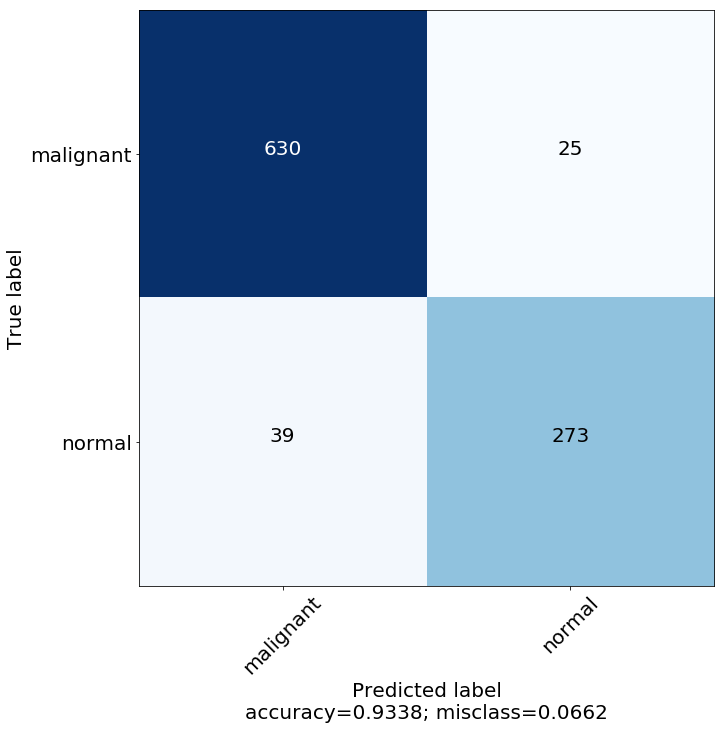

In [20]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [21]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[630  25]
 [ 39 273]]
              precision    recall  f1-score   support

      normal       0.94      0.96      0.95       655
   malignant       0.92      0.88      0.90       312

   micro avg       0.93      0.93      0.93       967
   macro avg       0.93      0.92      0.92       967
weighted avg       0.93      0.93      0.93       967



In [22]:
total=sum(sum(cm))

# accuracy = (cm[0,0]+cm[1,1]) / total
# print ('Accuracy : ', accuracy*100)

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Sensitivity :  94.17040358744396
Specificity :  91.61073825503355


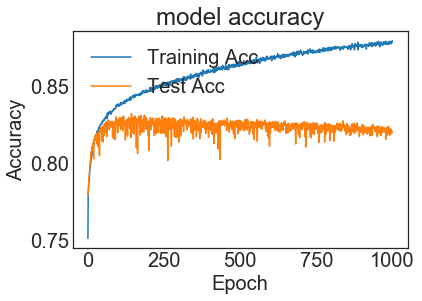

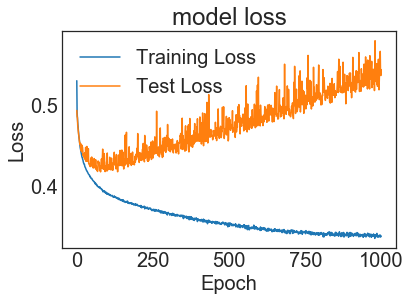

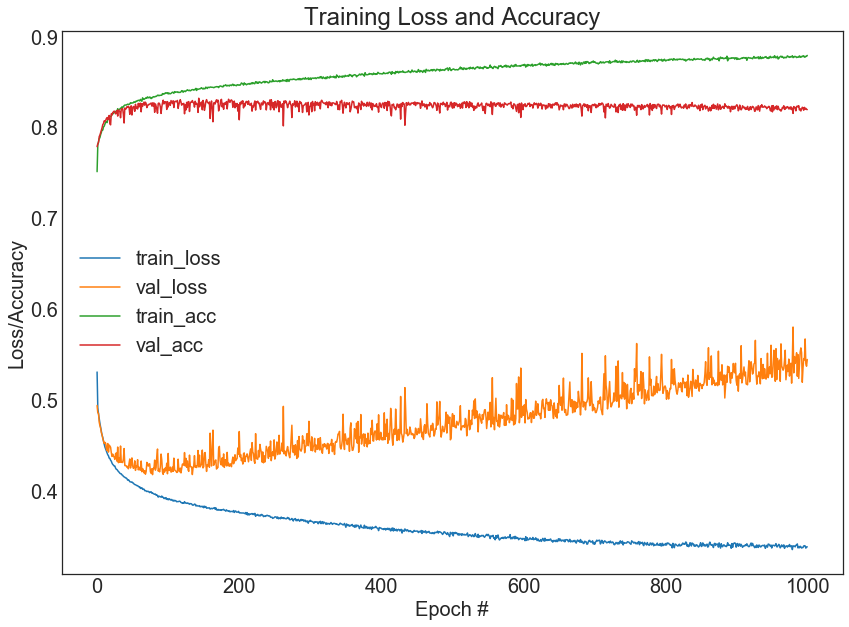

In [23]:
import seaborn
plt.style.use('seaborn-white')

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure(figsize=(14,10))
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="best")

In [24]:
y_pred_class = model.predict(test_data, verbose=1)

y_pred_class = [np.argmax(r) for r in y_pred_class]
test_y = [np.argmax(r) for r in test_labels]


from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, roc_curve

# Precision
print('Precision = ', precision_score(test_y, y_pred_class, average='weighted'))
# (None, 'micro', 'macro', 'weighted', 'samples')

# Recall
print('Recall = ', recall_score(test_y, y_pred_class, average='weighted'))

# f1_score
print('f1_score = ', f1_score(test_y, y_pred_class, average='weighted'))

967/967 [==============================] - 0s 34us/step
Precision =  0.933445343178348
Recall =  0.9338159255429163
f1_score =  0.9334063519654108


In [25]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

def multiclass_roc_auc_score(y_test, y_pred, average="weighted"):
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(y_test)

    truth = label_binarizer.transform(y_test)
    pred = label_binarizer.transform(y_pred)
    return roc_auc_score(truth, pred, average=average)
# roc_auc_score
print('roc_auc_score = ', multiclass_roc_auc_score(test_y, y_pred_class))

roc_auc_score =  0.9184160305343513


In [26]:
sample_count = test_generator.samples
print('Sample count: {}'.format(sample_count))

fnames = test_generator.filenames
ground_truth = test_generator.classes
label2index = test_generator.class_indices
# Getting the mapping from class index to class label
idx2label = dict((v, k) for k, v in label2index.items())
predictions = model.predict_classes(test_data)
prob = model.predict(test_data)
errors = np.where(predictions != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors), sample_count))

Sample count: 967
No of errors = 64/967
